# **Cora Dataset Overview and Description**

# **The Cora Dataset**

- The Cora dataset is a well-known graph dataset designed for tasks like node classification and link prediction, often used for evaluating graph neural networks (GNNs). It consists of a collection of scientific papers, each classified into one of seven topics, with citation relationships forming a graph structure.

**Key features of the dataset include:**

- **Nodes:** Represent scientific papers, with 2,708 nodes in total.

- **Edges:** Represent citations between papers, totaling 5,429 edges.

- **Node Features:** Each paper has a 1,433-dimensional feature vector based on a bag-of-words model, representing the frequency of words in the paper's abstract.

- **Labels:** Each node (paper) is labeled with one of seven categories: "Case Based," "Genetic Algorithms," "Neural Networks," "Probabilistic Methods," "Reinforcement Learning," "Rule Learning," and "Theory."

**Tasks Supported:**

- **Node classification** (predicting the topic of a scientific paper based on its feature vector and citations)

- **Link prediction** (predicting missing citations between papers based on their relationships)

The Cora dataset is widely used in the graph learning community, providing a benchmark for testing and comparing different GNN architectures. It is already structured as a graph, making it easy to apply graph-based learning algorithms without additional preprocessing.

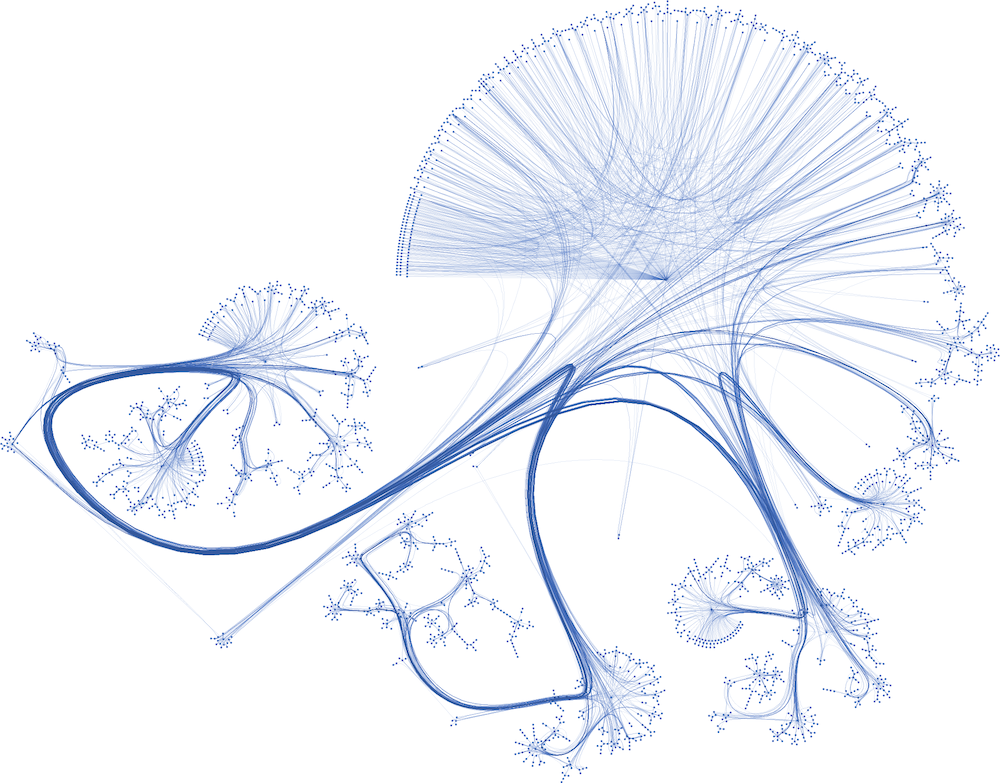



---



In [2]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py"



---



In [3]:
import  torch_geometric
from torch_geometric.datasets import Planetoid

In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [5]:
dataset

Cora()

In [6]:
num_classes = dataset.num_classes
num_classes

7

In [7]:
len(dataset)

1

In [8]:
num_features = dataset.num_features
num_features

1433

In [9]:
dataset.num_edge_features

0

In [10]:
dataset.data

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [11]:
import torch
from torch_geometric.nn import GCNConv

In [12]:
data = dataset [0] # to get first graph object

# GCN Architecture

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dimension, num_layers=2, activation_func="ReLU"):
        super(GCN, self).__init__()

        self.num_layers = num_layers
        self.activation_func = activation_func

        self.conv1 = GCNConv(num_features, hidden_dimension)
        self.convs = torch.nn.ModuleList([GCNConv(hidden_dimension, hidden_dimension) for _ in range(num_layers - 1)])
        self.conv_last = GCNConv(hidden_dimension, num_classes)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = self.applyActivation(x)

        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.applyActivation(x)

        x = self.conv_last(x, edge_index)
        return x

    def applyActivation(self, x):
        if self.activation_func == "ReLU":
            return torch.relu(x)
        elif self.activation_func == "Sigmoid":
            return torch.sigmoid(x)
        elif self.activation_func == "Tanh":
            return torch.tanh(x)
        else:
            raise ValueError("Unsupported activation function !!")

# Train and test

In [14]:
def train(data, mask, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[mask], data.y[mask])
    loss.backward()
    optimizer.step()
    return loss

def test(data, mask, model):
    model.eval()
    out = model(data.x, data.edge_index)
    predictedC = out.argmax(dim=1)
    correct = predictedC[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

# Model building

In [15]:
# 'First' model the default
model1 = GCN(hidden_dimension=8, num_layers=2, activation_func="ReLU")
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion1 = torch.nn.CrossEntropyLoss()

# 'Second' model after tuning - Mohamed Khairi
model2 = GCN(hidden_dimension=16, num_layers=3, activation_func="Tanh")
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005, weight_decay=0)
criterion2 = torch.nn.CrossEntropyLoss()

# 'Third' model after tuning - Mostapha Abdelaziz
model3 = GCN(hidden_dimension=32, num_layers=2, activation_func="Sigmoid")
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=5e-4)
criterion3 = torch.nn.CrossEntropyLoss()

# Train and test 'default' model

In [16]:
# Train and test 'default' model
num_epochs = 200
for epoch in range(1, num_epochs):
    loss1 = train(data, data.train_mask, model1, optimizer1, criterion1)
    if epoch % 10 == 0:
        train_acc1 = test(data, data.train_mask, model1)
        val_acc1 = test(data, data.val_mask, model1)
        test_acc1 = test(data, data.test_mask, model1)
        print(f'Model 1 - Epoch: {epoch:03d}, Loss: {loss1:.4f}, Train: {train_acc1:.4f}, Val: {val_acc1:.4f}, Test: {test_acc1:.4f}')

Model 1 - Epoch: 010, Loss: 1.3888, Train: 0.6286, Val: 0.6140, Test: 0.6220
Model 1 - Epoch: 020, Loss: 0.6878, Train: 0.9500, Val: 0.7320, Test: 0.7280
Model 1 - Epoch: 030, Loss: 0.2196, Train: 0.9857, Val: 0.7480, Test: 0.7520
Model 1 - Epoch: 040, Loss: 0.0575, Train: 1.0000, Val: 0.7520, Test: 0.7520
Model 1 - Epoch: 050, Loss: 0.0182, Train: 1.0000, Val: 0.7540, Test: 0.7540
Model 1 - Epoch: 060, Loss: 0.0079, Train: 1.0000, Val: 0.7640, Test: 0.7550
Model 1 - Epoch: 070, Loss: 0.0046, Train: 1.0000, Val: 0.7580, Test: 0.7530
Model 1 - Epoch: 080, Loss: 0.0033, Train: 1.0000, Val: 0.7600, Test: 0.7490
Model 1 - Epoch: 090, Loss: 0.0026, Train: 1.0000, Val: 0.7600, Test: 0.7470
Model 1 - Epoch: 100, Loss: 0.0021, Train: 1.0000, Val: 0.7580, Test: 0.7470
Model 1 - Epoch: 110, Loss: 0.0018, Train: 1.0000, Val: 0.7580, Test: 0.7460
Model 1 - Epoch: 120, Loss: 0.0016, Train: 1.0000, Val: 0.7560, Test: 0.7470
Model 1 - Epoch: 130, Loss: 0.0014, Train: 1.0000, Val: 0.7560, Test: 0.7450

# Train and test 'second' model after tuning - Mohamed Khairi

In [17]:
# Train and test 'second' model after tuning - Mohamed Khairi
num_epochs = 200
for epoch in range(1, num_epochs):
    loss2 = train(data, data.train_mask, model2, optimizer2, criterion2)
    if epoch % 10 == 0:
        train_acc2 = test(data, data.train_mask, model2)
        val_acc2 = test(data, data.val_mask, model2)
        test_acc2 = test(data, data.test_mask, model2)
        print(f'Model 2 - Epoch: {epoch:03d}, Loss: {loss2:.4f}, Train: {train_acc2:.4f}, Val: {val_acc2:.4f}, Test: {test_acc2:.4f}')

Model 2 - Epoch: 010, Loss: 1.0969, Train: 0.8714, Val: 0.6840, Test: 0.7010
Model 2 - Epoch: 020, Loss: 0.5868, Train: 0.9714, Val: 0.7380, Test: 0.7560
Model 2 - Epoch: 030, Loss: 0.2944, Train: 0.9929, Val: 0.7440, Test: 0.7550
Model 2 - Epoch: 040, Loss: 0.1619, Train: 1.0000, Val: 0.7260, Test: 0.7500
Model 2 - Epoch: 050, Loss: 0.1014, Train: 1.0000, Val: 0.7320, Test: 0.7460
Model 2 - Epoch: 060, Loss: 0.0702, Train: 1.0000, Val: 0.7260, Test: 0.7380
Model 2 - Epoch: 070, Loss: 0.0527, Train: 1.0000, Val: 0.7220, Test: 0.7380
Model 2 - Epoch: 080, Loss: 0.0418, Train: 1.0000, Val: 0.7240, Test: 0.7380
Model 2 - Epoch: 090, Loss: 0.0345, Train: 1.0000, Val: 0.7200, Test: 0.7360
Model 2 - Epoch: 100, Loss: 0.0292, Train: 1.0000, Val: 0.7180, Test: 0.7300
Model 2 - Epoch: 110, Loss: 0.0253, Train: 1.0000, Val: 0.7120, Test: 0.7300
Model 2 - Epoch: 120, Loss: 0.0222, Train: 1.0000, Val: 0.7120, Test: 0.7320
Model 2 - Epoch: 130, Loss: 0.0197, Train: 1.0000, Val: 0.7100, Test: 0.7300

# Train and test 'third' model after tuning -  Mostapha Abdelaziz

In [18]:
# Train and test 'third' model after tuning -  Mostapha Abdelaziz
num_epochs = 200
for epoch in range(1, num_epochs):
    loss3 = train(data, data.train_mask, model3, optimizer3, criterion3)
    if epoch % 10 == 0:
        train_acc3 = test(data, data.train_mask, model3)
        val_acc3 = test(data, data.val_mask, model3)
        test_acc3 = test(data, data.test_mask, model3)
        print(f'Model 3 - Epoch: {epoch:03d}, Loss: {loss3:.4f}, Train: {train_acc3:.4f}, Val: {val_acc3:.4f}, Test: {test_acc3:.4f}')

Model 3 - Epoch: 010, Loss: 1.7723, Train: 0.8214, Val: 0.6320, Test: 0.6330
Model 3 - Epoch: 020, Loss: 1.3938, Train: 0.8000, Val: 0.6160, Test: 0.6220
Model 3 - Epoch: 030, Loss: 0.8809, Train: 0.9571, Val: 0.7920, Test: 0.7930
Model 3 - Epoch: 040, Loss: 0.5073, Train: 0.9786, Val: 0.8000, Test: 0.7990
Model 3 - Epoch: 050, Loss: 0.3015, Train: 1.0000, Val: 0.7860, Test: 0.7990
Model 3 - Epoch: 060, Loss: 0.1940, Train: 1.0000, Val: 0.7900, Test: 0.7970
Model 3 - Epoch: 070, Loss: 0.1405, Train: 1.0000, Val: 0.7900, Test: 0.7990
Model 3 - Epoch: 080, Loss: 0.1110, Train: 1.0000, Val: 0.7780, Test: 0.7990
Model 3 - Epoch: 090, Loss: 0.0931, Train: 1.0000, Val: 0.7860, Test: 0.7980
Model 3 - Epoch: 100, Loss: 0.0811, Train: 1.0000, Val: 0.7880, Test: 0.8010
Model 3 - Epoch: 110, Loss: 0.0725, Train: 1.0000, Val: 0.7880, Test: 0.8000
Model 3 - Epoch: 120, Loss: 0.0661, Train: 1.0000, Val: 0.7900, Test: 0.8010
Model 3 - Epoch: 130, Loss: 0.0610, Train: 1.0000, Val: 0.7900, Test: 0.8010



---



# Graph SAGE model

In [44]:
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

# Define the GraphSAGE model
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, output_dim, aggregator_type="max"):
        super(SAGE, self).__init__()

        self.conv = SAGEConv(input_dim, output_dim, aggr=aggregator_type)

    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [46]:
# Train function
def train(data, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test(data, model):
    model.eval()
    logits = model(data.x, data.edge_index)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].argmax(dim=1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs  # Returns train, val, and test accuracy